# Import Library

In [0]:
import sklearn
sklearn.__version__
import scipy

import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score,explained_variance_score
from graphviz import Digraph

# Conditional Causality


In [0]:
df = pd.read_csv("synth_data_with_header.csv", header='infer')
# g = Digraph('G', filename='boosting_causality.gv', strict=True)
n = df.shape[0]
k = df.shape[1]

## Functions: regression, boosting, causality_test

In [0]:
def regression(df, x_name, y_name, maxlag):
    data = df
    df_list = []     
    
    v = 0.1
    # add lagged columns of current x variable as x_name
    for lag in range(1,maxlag+1):
        data['{}_{}'.format(x_name,str(lag))] = data['{}'.format(x_name)].shift(lag)
        df_list.append(data['{}_{}'.format(x_name,str(lag))])

    # create test dataframe X, and y
    X = pd.concat(df_list,axis = 1)  
    y = data[y_name]

    # remove NaN rows, the number of removal is maxlag
    X = X.iloc[maxlag:]
    y = y.iloc[maxlag:]
#     print(y)
    print("y is ")
    print(y_name)
    print("X are")
    print(x_name)
    # build regression reg_y, X→y
    reg_y = DecisionTreeRegressor(random_state = 0, max_depth=8, min_samples_leaf=10)
#     reg_y = DecisionTreeRegressor(random_state = 0)
    # fit model using data X, y
    reg_y.fit(X, y)
    # check number of features
#     print(reg_y.n_features_)
    # check feature importance 
    print(reg_y.feature_importances_)

#     print(reg_y.decision_path)
    # y_hat is the predicted value of y
    y_hat = reg_y.predict(X) 

    # save predicted y_hat as a pd dataframe and move its index to match the place in original df
    y_hat_df = pd.DataFrame(y_hat)
    y_hat_df.index += maxlag
    # save the predicted value into dataframe
    data['predicted_{}'.format(y_name)] = y_hat_df  

    # compuate mse
    reg_mse = mean_squared_error(y,y_hat)
    # compute residual value of y, y-y_hat, the residual value is the y in next round of loop
    if y_name == x_name:
        # learning rate is not in model 0
        y_residual = y - y_hat
        # apply leraning rate
    else:
        y_residual = y - (y_hat * v)
        
    data["{}res{}".format(y_name,x_name)] = y_residual

    # print mse, r^2, variance
    print("the mse is")
    print(reg_mse)
    print("regression score is")
#     print(r2_score(data['{}'.format(y_name)].iloc[3:], data['predicted_{}'.format(y_name)].iloc[3:]))
    # score is the r2_score, same results
    print(reg_y.score(X,y))
    r2 = reg_y.score(X,y)
#     print("var_reg is")
  #   print(df['predicted_{}'.format(y_name)].var(ddof=0))
#     var_reg = df['predicted_{}'.format(y_name)].var(ddof=0)  

    #print explained_variance_score
    print("explained_variance_score")
    variance_score = explained_variance_score(y,y_hat)
    print(variance_score)

#     print(data.head(10))
    return reg_mse,reg_y.score(X,y),variance_score,r2


def boosting(x_list, y_name, maxlag):
  
    # loop through each variable in the list
    temp_y_name = y_name
    mse_arr = []
    r2_arr = []
    
    predicted_name_list = []
    
    for pivot_x in range(0,len(x_list)):
        print("=========this is regression round {}=========".format(pivot_x+1))

        # save return value of regression in res_list
        res_list = regression(df, x_list[pivot_x],y_name,3)  
        
        # save predicted column name as a list
        predicted_name_list.append('predicted_{}'.format(y_name))
        
        # build y_name such as x1resx1, which means x1 substacts x1_hat, res means residual
        y_name = str(y_name) +"res"+ str(x_list[pivot_x])
        
        # example: [0.7614110755692759, 0.6019695603895466, 0.4941602516989991, 0.36284165024184334]
        mse_arr.append(res_list[0])
        r2_arr.append(res_list[3])
    
    return mse_arr,predicted_name_list,r2_arr,maxlag


def causality_test(boosting_result_list):
    
    mse_arr = boosting_result_list[0]
    name_list = boosting_result_list[1]
    r2_arr =  boosting_result_list[2]
    maxlag = boosting_result_list[3]
    
    print('------------Causalilty Test Criterias------------')
    
    # mse_y means the mse to predict y using all other varaibles except for the causing variable

    mse_y = mse_arr[len(mse_arr)-2]
#     print(mse_arr[len(mse_arr)-1])
    mse_all = mse_arr[len(mse_arr)-1]

    print("mse before adding causing variable is ")
    print(mse_y)
    print("mse of all variables is")
    print(mse_all)
    print("\n!!!!!!!!!!!!!!!!!!!!!!!")
    print("change of mse (ratio)")
#     mse_change = mse_y/mse_all
    mse_change = ((mse_y-mse_all)/(3-2))/(mse_all/(999-3))
    
    print(np.log(mse_change))
    print("!!!!!!!!!!!!!!!!!!!!!!!\n")
    
    print("~~~~~~~~~~~~~~~~~")
    print("the F-score is")
    f_score = ((mse_y-mse_all)/mse_all)*((n-k*maxlag)/maxlag)
    print(n-k*maxlag)
    print(maxlag)
    print(k*maxlag)
    print(f_score)
    p_value = scipy.stats.f.sf(f_score, maxlag, n-k*maxlag)
    print("the p_value is")
    print(p_value)
    print("~~~~~~~~~~~~~~~~~")
    
    
    df['pred_y'] = df[name_list[0]]
    for key in range(1, len(name_list)):
        df['pred_y'] += df[name_list[key]]

    df['last_step'] = df['pred_y'] - df[name_list[len(name_list)-1]]

    # df['step_3'] = df['predicted_x3'] + df['predicted_x3resx3'] + df['predicted_x3resx3resx4']

    r2_y = r2_arr[len(r2_arr)-2]
#     print(mse_arr[len(mse_arr)-1])
    r2_all = r2_arr[len(r2_arr)-1]
  
    print("r_square_last is")
    print(r2_y)
    print("r_square_final is ")
    print(r2_all)
    print("\n!!!!!!!!!!!!!!!!!!!!!!!")
    print("r-square change")
    r_square_change = abs(r2_all-r2_y)/r2_y
    print(r_square_change)
    print("!!!!!!!!!!!!!!!!!!!!!!!\n")
    
    
#     # draw graph if var_change >0.05  -- to do
#     if var_change > 0.05:
#         g.edge(,,label = " {} ".format(temp_lag))

    return name_list



## Tests of causality should exist


###: x1→x3|x4, x2

mse stable   r2 not stable if change x4 x2 position

0.36683870563049154

In [0]:
causality_test(boosting(["x3","x4","x2","x1"], "x3", 3))
# print(g)
# print(g.view())
# g

=========this is regression round 1=========
y is 
x3
X are
x3
[0.67802247 0.06310569 0.25887184]
the mse is
1.7193309403310961
regression score is
0.699098301511516
explained_variance_score
0.699098301511516
=========this is regression round 2=========
y is 
x3resx3
X are
x4
[0.38515286 0.32399318 0.29085396]
the mse is
1.3904025020511124
regression score is
0.19131188217705275
explained_variance_score
0.19131188217705264
=========this is regression round 3=========
y is 
x3resx3resx4
X are
x2
[0.58395382 0.24613909 0.16990709]
the mse is
1.193476504238941
regression score is
0.2796646390784199
explained_variance_score
0.2796646390784199
=========this is regression round 4=========
y is 
x3resx3resx4resx2
X are
x1
[0.57816307 0.20549126 0.21634567]
the mse is
1.027780772004482
regression score is
0.3448603659465288
explained_variance_score
0.3448603659465289
------------Causalilty Test Criterias------------
mse before adding causing variable is 
1.193476504238941
mse of all variables 

['predicted_x3',
 'predicted_x3resx3',
 'predicted_x3resx3resx4',
 'predicted_x3resx3resx4resx2']

### X2→x3
 change x1 x4 cause large difference between r2, mse similar
 
 0.3127685509289654


In [0]:
causality_test(boosting(["x3","x4","x1","x2"], "x3", 3))

=========this is regression round 1=========
y is 
x3
X are
x3
[0.67802247 0.06310569 0.25887184]
the mse is
1.7193309403310961
regression score is
0.699098301511516
explained_variance_score
0.699098301511516
=========this is regression round 2=========
y is 
x3resx3
X are
x4
[0.38515286 0.32399318 0.29085396]
the mse is
1.3904025020511124
regression score is
0.19131188217705275
explained_variance_score
0.19131188217705264
=========this is regression round 3=========
y is 
x3resx3resx4
X are
x1
[0.58354713 0.19466934 0.22178352]
the mse is
1.0666678097997941
regression score is
0.3562013671601061
explained_variance_score
0.3562013671601061
=========this is regression round 4=========
y is 
x3resx3resx4resx1
X are
x2
[0.58080487 0.22707413 0.192121  ]
the mse is
1.1052467610026073
regression score is
0.2844923186037267
explained_variance_score
0.2844923186037268
------------Causalilty Test Criterias------------
mse before adding causing variable is 
1.0666678097997941
mse of all variabl

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in log


['predicted_x3',
 'predicted_x3resx3',
 'predicted_x3resx3resx4',
 'predicted_x3resx3resx4resx1']

### X4→x3

mse stable , r2 not   

0.28674225600921976

In [0]:
causality_test(boosting(["x3","x1","x2","x4"], "x3", 3))

=========this is regression round 1=========
y is 
x3
X are
x3
[0.67802247 0.06310569 0.25887184]
the mse is
1.7193309403310961
regression score is
0.699098301511516
explained_variance_score
0.699098301511516
=========this is regression round 2=========
y is 
x3resx3
X are
x1
[0.55644369 0.21420652 0.22934978]
the mse is
1.1246576783441986
regression score is
0.3458748098096692
explained_variance_score
0.3458748098096691
=========this is regression round 3=========
y is 
x3resx3resx1
X are
x2
[0.58348036 0.23170455 0.18481509]
the mse is
1.154274349220922
regression score is
0.2814272328813491
explained_variance_score
0.2814272328813491
=========this is regression round 4=========
y is 
x3resx3resx1resx2
X are
x4
[0.38045106 0.30663254 0.31291639]
the mse is
1.2306990527413255
regression score is
0.19056919030836272
explained_variance_score
0.1905691903083626
------------Causalilty Test Criterias------------
mse before adding causing variable is 
1.154274349220922
mse of all variables 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in log


['predicted_x3',
 'predicted_x3resx3',
 'predicted_x3resx3resx1',
 'predicted_x3resx3resx1resx2']

## Tests of no causality


### X4→x1

In [0]:
causality_test(boosting(["x1","x2","x3","x4"], "x1", 3))

=========this is regression round 1=========
y is 
x1
X are
x1
[0.57814715 0.0410388  0.38081405]
the mse is
1.058481185715396
regression score is
0.897272952026542
explained_variance_score
0.8972729520265421
=========this is regression round 2=========
y is 
x1resx1
X are
x2
[0.38564578 0.29727728 0.31707694]
the mse is
0.9015077316524469
regression score is
0.14830065586555996
explained_variance_score
0.14830065586556007
=========this is regression round 3=========
y is 
x1resx1resx2
X are
x3
[0.27320635 0.36119419 0.36559946]
the mse is
0.8890270758749255
regression score is
0.13573937489695465
explained_variance_score
0.13573937489695465
=========this is regression round 4=========
y is 
x1resx1resx2resx3
X are
x4
[0.46551592 0.33884304 0.19564104]
the mse is
0.8529399872465963
regression score is
0.14887010242119136
explained_variance_score
0.14887010242119136
------------Causalilty Test Criterias------------
mse before adding causing variable is 
0.8890270758749255
mse of all var

['predicted_x1',
 'predicted_x1resx1',
 'predicted_x1resx1resx2',
 'predicted_x1resx1resx2resx3']

In [0]:
# # print(df)
# for col in df.columns: 
#     print(col)

### X2→x1

In [0]:
causality_test(boosting(["x1","x4","x3","x2"], "x1", 3))

=========this is regression round 1=========
y is 
x1
X are
x1
[0.57814715 0.0410388  0.38081405]
the mse is
1.058481185715396
regression score is
0.897272952026542
explained_variance_score
0.8972729520265421
=========this is regression round 2=========
y is 
x1resx1
X are
x4
[0.4606989  0.34295923 0.19634187]
the mse is
0.9005429124496113
regression score is
0.1492121687161012
explained_variance_score
0.1492121687161012
=========this is regression round 3=========
y is 
x1resx1resx4
X are
x3
[0.27418409 0.3187954  0.4070205 ]
the mse is
0.9265648661359537
regression score is
0.09908675891416452
explained_variance_score
0.09908675891416452
=========this is regression round 4=========
y is 
x1resx1resx4resx3
X are
x2
[0.32067412 0.40214923 0.27717665]
the mse is
0.8708260087419
regression score is
0.13703592598887837
explained_variance_score
0.13703592598887837
------------Causalilty Test Criterias------------
mse before adding causing variable is 
0.9265648661359537
mse of all variable

['predicted_x1',
 'predicted_x1resx1',
 'predicted_x1resx1resx4',
 'predicted_x1resx1resx4resx3']

### X3→x1

In [0]:
causality_test(boosting(["x1","x4","x2","x3"], "x1", 3))

=========this is regression round 1=========
y is 
x1
X are
x1
[0.57814715 0.0410388  0.38081405]
the mse is
1.058481185715396
regression score is
0.897272952026542
explained_variance_score
0.8972729520265421
=========this is regression round 2=========
y is 
x1resx1
X are
x4
[0.4606989  0.34295923 0.19634187]
the mse is
0.9005429124496113
regression score is
0.1492121687161012
explained_variance_score
0.1492121687161012
=========this is regression round 3=========
y is 
x1resx1resx4
X are
x2
[0.31985411 0.40258975 0.27755615]
the mse is
0.8883159495939721
regression score is
0.136276767546331
explained_variance_score
0.1362767675463309
=========this is regression round 4=========
y is 
x1resx1resx4resx2
X are
x3
[0.27419393 0.34747861 0.37832746]
the mse is
0.8709726451734207
regression score is
0.13062968308275802
explained_variance_score
0.13062968308275813
------------Causalilty Test Criterias------------
mse before adding causing variable is 
0.8883159495939721
mse of all variable

['predicted_x1',
 'predicted_x1resx1',
 'predicted_x1resx1resx4',
 'predicted_x1resx1resx4resx2']

x2→x4

In [0]:
causality_test(boosting(["x4","x1","x3","x2"], "x4", 3))

=========this is regression round 1=========
y is 
x4
X are
x4
[0.98086417 0.01212027 0.00701556]
the mse is
1.2110282771944438
regression score is
0.9258698185089883
explained_variance_score
0.9258698185089883
=========this is regression round 2=========
y is 
x4resx4
X are
x1
[0.26069394 0.61873655 0.12056951]
the mse is
0.7550058181917545
regression score is
0.37655806027844707
explained_variance_score
0.37655806027844707
=========this is regression round 3=========
y is 
x4resx4resx1
X are
x3
[0.66810892 0.15492827 0.1769628 ]
the mse is
0.6895629633031214
regression score is
0.3867193439428446
explained_variance_score
0.3867193439428446
=========this is regression round 4=========
y is 
x4resx4resx1resx3
X are
x2
[0.33958409 0.36268442 0.29773149]
the mse is
0.846400002373468
regression score is
0.18753504298148693
explained_variance_score
0.18753504298148682
------------Causalilty Test Criterias------------
mse before adding causing variable is 
0.6895629633031214
mse of all vari

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in log


['predicted_x4',
 'predicted_x4resx4',
 'predicted_x4resx4resx1',
 'predicted_x4resx4resx1resx3']

X4  --- >x2

In [0]:
causality_test(boosting(["x2","x1","x3","x4"], "x2", 3))

=========this is regression round 1=========
y is 
x2
X are
x2
[0.11944973 0.76488826 0.11566201]
the mse is
0.8333141366146709
regression score is
0.42211496112936825
explained_variance_score
0.4221149611293683
=========this is regression round 2=========
y is 
x2resx2
X are
x1
[0.35211085 0.34093816 0.30695099]
the mse is
0.6475341136645097
regression score is
0.22294116322673987
explained_variance_score
0.22294116322673985
=========this is regression round 3=========
y is 
x2resx2resx1
X are
x3
[0.15781501 0.18595021 0.65623479]
the mse is
0.6707275929952561
regression score is
0.1947494794193434
explained_variance_score
0.1947494794193435
=========this is regression round 4=========
y is 
x2resx2resx1resx3
X are
x4
[0.1801869  0.36965661 0.45015648]
the mse is
0.6898310847605017
regression score is
0.17149199838230425
explained_variance_score
0.17149199838230422
------------Causalilty Test Criterias------------
mse before adding causing variable is 
0.6707275929952561
mse of all va

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in log


['predicted_x2',
 'predicted_x2resx2',
 'predicted_x2resx2resx1',
 'predicted_x2resx2resx1resx3']

# Single variable decision tree with lag 3 (x1 = f(x1t-1, x1t-2, x1t-3))

In [0]:
data = pd.read_csv("synth_data_with_header.csv", header='infer')

data["x1_1"] = data.x1.shift(1)
data["x1_2"] = data.x1.shift(2)
data["x1_3"] = data.x1.shift(3)

data
#remove first 3 rows containing NaN
data = data.iloc[3:]

X = data[["x1_1","x1_2","x1_3"]]
x1 = data["x1"]
# data = data.iloc[3:]

# print(X)
# print(x1)

reg_x1 = DecisionTreeRegressor(random_state = 0, max_depth=5)

reg_x1.fit(X, x1)

x1_hat = reg_x1.predict(X)
# print("x1 is")
# print(x1)
# print("x1_hat is")
# print(x1_hat)
# print(x1_hat.size)
# print(X.size)

# print(data)

print(reg_x1.feature_importances_)

print(reg_x1.score(X,x1))

# print(X)
# print(x1)

print("=====")
print(mean_squared_error(x1, x1_hat))


[0.58845279 0.01350344 0.39804377]
0.8596096303862996
=====
1.4465573363903832


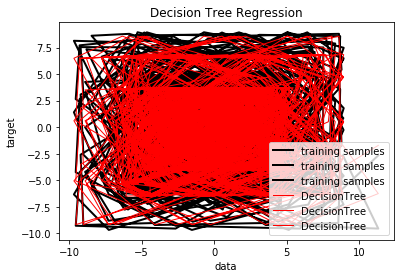

In [0]:
plt.figure()
plt.plot(X, x1, c="k", label="training samples", linewidth=2)
plt.plot(X, x1_hat, c="r", label="DecisionTree", linewidth=1)
# plt.plot(X, y2_hat, c="b", label="Ada", linewidth=2)

plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()